# Read BUFR files 

Utility to read and convert BUFR files from:


https://confluence.ecmwf.int/display/TCBUF/Radiosonde+BUFR+templates

https://confluence.ecmwf.int/display/TCBUF/Data+availability (see radiosondes)

https://www.ncei.noaa.gov/data/ecmwf-global-upper-air-bufr/doc/


See some BUFR instructions:
https://confluence.ecmwf.int/display/ECC/BUFR+tools



In [1]:
from eccodes import * 
import os,sys
import pandas as pd

In [49]:
# Taken from https://confluence.ecmwf.int/display/ECC/bufr_read_tempf
# (C) Copyright 2005- ECMWF.
#
# This software is licensed under the terms of the Apache Licence Version 2.0
# which can be obtained at http://www.apache.org/licenses/LICENSE-2.0.
#
# In applying this licence, ECMWF does not waive the privileges and immunities
# granted to it by virtue of its status as an intergovernmental organisation
# nor does it submit to any jurisdiction.
#
# Python implementation: bufr_read_tempf
#
#
# Description: read and print radiosonde data from TEMP BUFR messages.
# If available this version also lists the position information from the WMO list
# (now OSCAR/Surface) appended to the reports by ECMWF
#
# Author: Bruce Ingleby
#
# Please note that TEMP reports can be encoded in various ways in BUFR.
# Therefore the code below might not work directly for other types of TEMP
# messages than the one used in the example. It is advised to use bufr_dump to
# understand the structure of the messages.
#

from __future__ import print_function
import traceback
import sys
import numpy as np
from eccodes import *
 



VERBOSE = 1  # verbose error reporting
PRINT = False

def read_bufr_highres(INPUT, save_csv=True, out_dir='SAVE_CSV'):
    # open BUFR file
    f = open(INPUT, "rb")
    llstdonly = 1
    cnt = 0
    # loop over the messages in the file
    
    # dictionary to hold data 
    data = {'blockNumber': [], 
            'stationNumber': [] ,
            'statid': [] , 
            'latitude': [], 
            'longitude': [] , 
            
            'pressure': [],
            'airTemperature': [] , 
            'radiosondeType': [] , 
            'year':[] ,
            'month': [],
            'day': [],
            'hour': [],
            'minute': [],
            'second':[],
            'date':[],
            'time':[],
            'timePeriod': [], 
            'windSpeed': [],
            'windDirection': [],

            "latitudeDisplacement": [],
            "longitudeDisplacement": [],
            "airTemperature": [],
            "dewpointTemperature": [],
            'nonCoordinateGeopotentialHeight':[]
      }
    
    
    while 1:
        
        # will fill a dictionary for each bufr message
        data = {'blockNumber': [], 
        'stationNumber': [] ,
        'statid': [] , 
        'latitude': [], 
        'longitude': [] , 

        'pressure': [],
        'airTemperature': [] , 
        'radiosondeType': [] , 
        'year':[] ,
        'month': [],
        'day': [],
        'hour': [],
        'minute': [],
        'second':[],
        'date':[],
        'time':[],
        'timePeriod': [], 
        'windSpeed': [],
        'windDirection': [],

        "latitudeDisplacement": [],
        "longitudeDisplacement": [],
        "airTemperature": [],
        "dewpointTemperature": [],
        'nonCoordinateGeopotentialHeight':[]
          }

    
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        cnt += 1
 
        # desc = codes_get_array(bufr, 'unexpandedDescriptors')
        # if all(desc != 309056):    # descent reports
        #     codes_release(bufr)
        #     continue   # Skip other templates
 
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        
        #codes_set(bufr, "unpack", 1)
                
        
        ### Changed here, without it raises errors...
        try:
            codes_set(bufr, "unpack", 1)
        except:
            continue
        
        
        # get header information from the message
        try:
            sid = codes_get(bufr, "aircraftRegistrationNumberOrOtherIdentification")
        except Exception:
            sid = "UNKNOWN"
 
        statid = "00000   "
        try:
            block = codes_get(bufr, "blockNumber")
            stnum = codes_get(bufr, "stationNumber")
            if (block > 0) and (block < 100):  # or block != CODES_MISSING_LONG
                statid = str.format("%.2i%.3i   " % (block, stnum))
        except Exception:
            statid = "00000   "
        if statid == "00000   ":
            statid = sid[0:8]

        try:
            pressure = codes_get_array(bufr, "pressure")
        except Exception:
            codes_release(bufr)  #if not pressure available, stop and move forward
            print('No pressure available! +++ ')
            continue
            
            
        # subtype = codes_get(bufr,'rdbSubtype')
        sondetype = codes_get(bufr, "radiosondeType")
        slat = codes_get_array(bufr, "latitude")
        slon = codes_get_array(bufr, "longitude")
        try:
            htg = codes_get(bufr, "heightOfStationGroundAboveMeanSeaLevel")
        except Exception:
            htg = -999.0
        try:
            htp = codes_get(bufr, "heightOfBarometerAboveMeanSeaLevel")
        except Exception:
            htp = -999.0
        year = codes_get(bufr, "year")
        month = codes_get(bufr, "month")
        day = codes_get(bufr, "day")
        hour = codes_get(bufr, "hour")
        minute = codes_get(bufr, "minute")
        try:
            second = codes_get(bufr, "second")
        except Exception:
            second = 0.0
        date = str.format("%i%.2i%.2i" % (year, month, day))
        time = str.format("%.2i%.2i%.2i" % (hour, minute, second))
        try:
            windsp = codes_get_array(bufr, "windSpeed")
        except Exception:
            windsp = np.empty(len(pressure))
            
            #codes_release(bufr)
            #continue
        if PRINT:
            print(
                "Ob: %7i %s %s %s %7.3f %8.3f %6.1f %6.1f %3i %4i"
                % (
                    cnt,
                    statid,
                    date,
                    time,
                    slat[0],
                    slon[0],
                    htg,
                    htp,
                    sondetype,
                    len(windsp),
                )
            )
 
        try:
            rsnumber = codes_get(bufr, "radiosondeSerialNumber")
            rssoftware = codes_get(bufr, "softwareVersionNumber")
            balloonwt = codes_get(bufr, "weightOfBalloon")
            if PRINT: print("RS number/software/balloonwt ", rsnumber, rssoftware, balloonwt)
        except Exception:
            rsnumber = 0
        try:
            htec = codes_get(
                bufr, "heightOfStation"
            )  # Height from WMO list (appended by ECMWF)
            if PRINT: print("WMO list lat, lon, ht: %7.3f %8.3f %6.1f" % (slat[1], slon[1], htec))
        except Exception:
            htec = 0
 
        # get all the timePeriods
        dtime = codes_get_array(bufr, "timePeriod")
     
    
        vsSignif = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        try:
            geopoth = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        except Exception:
            geopoth = np.empty( len(pressure) )
            #codes_release(bufr)
            #continue
        dlat = codes_get_array(bufr, "latitudeDisplacement")
        dlon = codes_get_array(bufr, "longitudeDisplacement")
        try:
            airt = codes_get_array(bufr, "airTemperature")
        except:
            airt = np.empty( len(pressure) )

        try:
            dewt = codes_get_array(bufr, "dewpointTemperature")
        except:
            dewt = np.empty( len(pressure) )
            
        try:
            windd = codes_get_array(bufr, "windDirection")
        except:
            windd = np.empty( len(pressure) )
  
        dtime = np.where(dtime != CODES_MISSING_LONG, dtime, np.nan)
        dlat = np.where(dlat != CODES_MISSING_DOUBLE, dlat, np.nan)
        dlon = np.where(dlon != CODES_MISSING_DOUBLE, dlon, np.nan)
        airt = np.where(airt != CODES_MISSING_DOUBLE, airt, np.nan)
        dewt = np.where(dewt != CODES_MISSING_DOUBLE, dewt, np.nan)
        windd = np.where(windd != CODES_MISSING_LONG, windd, np.nan)
        windsp = np.where(windsp != CODES_MISSING_DOUBLE, windsp, np.nan)
        geopoth = np.where(geopoth != CODES_MISSING_DOUBLE, geopoth, np.nan)
        pressure = np.where(pressure != CODES_MISSING_DOUBLE, pressure, np.nan)
        # pressure = np.where(pressure > -1e10, pressure, np.nan)
        
        if PRINT:
            print(
                "level  dtime   dlat   dlon pressure geopotH airTemp  dewPtT windDir  windSp  signif"
            )

        
        for i in range(0, len(windsp)):
            if (not llstdonly) or vsSignif[i] != 65536:
                continue
            if PRINT:
                print(
                    "%5i %6.1f %6.3f %6.3f %8.1f %7.1f %7.2f %7.2f %7.2f %7.2f %7i"
                    % (
                        i + 1,
                        dtime[i],
                        dlat[i],
                        dlon[i],
                        pressure[i],
                        geopoth[i],
                        airt[i],
                        dewt[i],
                        windd[i],
                        windsp[i],
                        vsSignif[i],
                    )
                )
            # delete handle
            
            data['timePeriod'].append(dtime[i])
            data['pressure'].append(pressure[i])
            data['windDirection'].append(windd[i])
            data['windSpeed'].append(windsp[i])
            data['latitudeDisplacement'].append(dlat[i])
            data['longitudeDisplacement'].append(dlon[i])
            data['nonCoordinateGeopotentialHeight'].append(geopoth[i])
            
            data['airTemperature'].append(dlon[i])
            data['dewpointTemperature'].append(dlon[i])

            # these are fixed, from header
            data['radiosondeType'].append(sondetype)
            data['latitude'].append(slat[0])
            data['longitude'].append(slon[0])
            data['year'].append(year)
            data['month'].append(month)
            data['day'].append(day)
            data['hour'].append(hour)
            data['minute'].append(minute)
            data['second'].append(second)
            data['date'].append(date)
            data['time'].append(time)

            
            data['blockNumber'].append(block)
            data['stationNumber'].append(stnum)
            data['statid'].append(statid)
            
            
        codes_release(bufr)
        
        if save_csv:
            sid =  statid.replace(' ','')
            out = out_dir + '/' + sid 
            if not os.path.isdir(out):
                os.makedirs(out)
                
            name = statid.replace(' ','') + '_' + str(date) + '_' + str(time) 
            try:
                df = pd.DataFrame.from_dict(data)
                df.to_csv(out + '/' + name + '.csv' , sep = '\t')

            except:
                print('CHECK DATA ' , data )
    # close the file
    
    f.close()
    return 0

    

In [47]:
data_dir = '/users/staff/federico/BUFR_CNR_EMANUELE_FABIO/ALL_DATA/d202210_c20221102/'
input_test = data_dir + '/' + os.listdir(data_dir)[0] 



In [48]:
import glob
for f in glob.glob(data_dir+'/*')[:1]:
    dummy = read_bufr_highres( f )


In [32]:
def quick_analysis():
    """ Reads files from the directory and check which stations are there """
    stations, lats, lons = [], [], [] 
    for station in os.listdir('SAVE_CSV'):
        file = os.listdir('SAVE_CSV/' + station )[0]
        df = pd.read_csv('SAVE_CSV/' + station + '/' + file , sep='\t')
        try:
            lat, lon = df.latitude[0], df.longitude[0]
        except:
            pass
            #print(file)
        stations.append(station)
        lats.append(lat)
        lons.append(lon)
        
    
    map_data = pd.DataFrame.from_dict( { 'station':stations, 'lat':lats , 'lon':lons} )
    
    try:
        date = file.split('_')[1][0:6]
    except:
        print( file)
        
    return map_data, date 


        

In [33]:
map_data, date = quick_analysis()

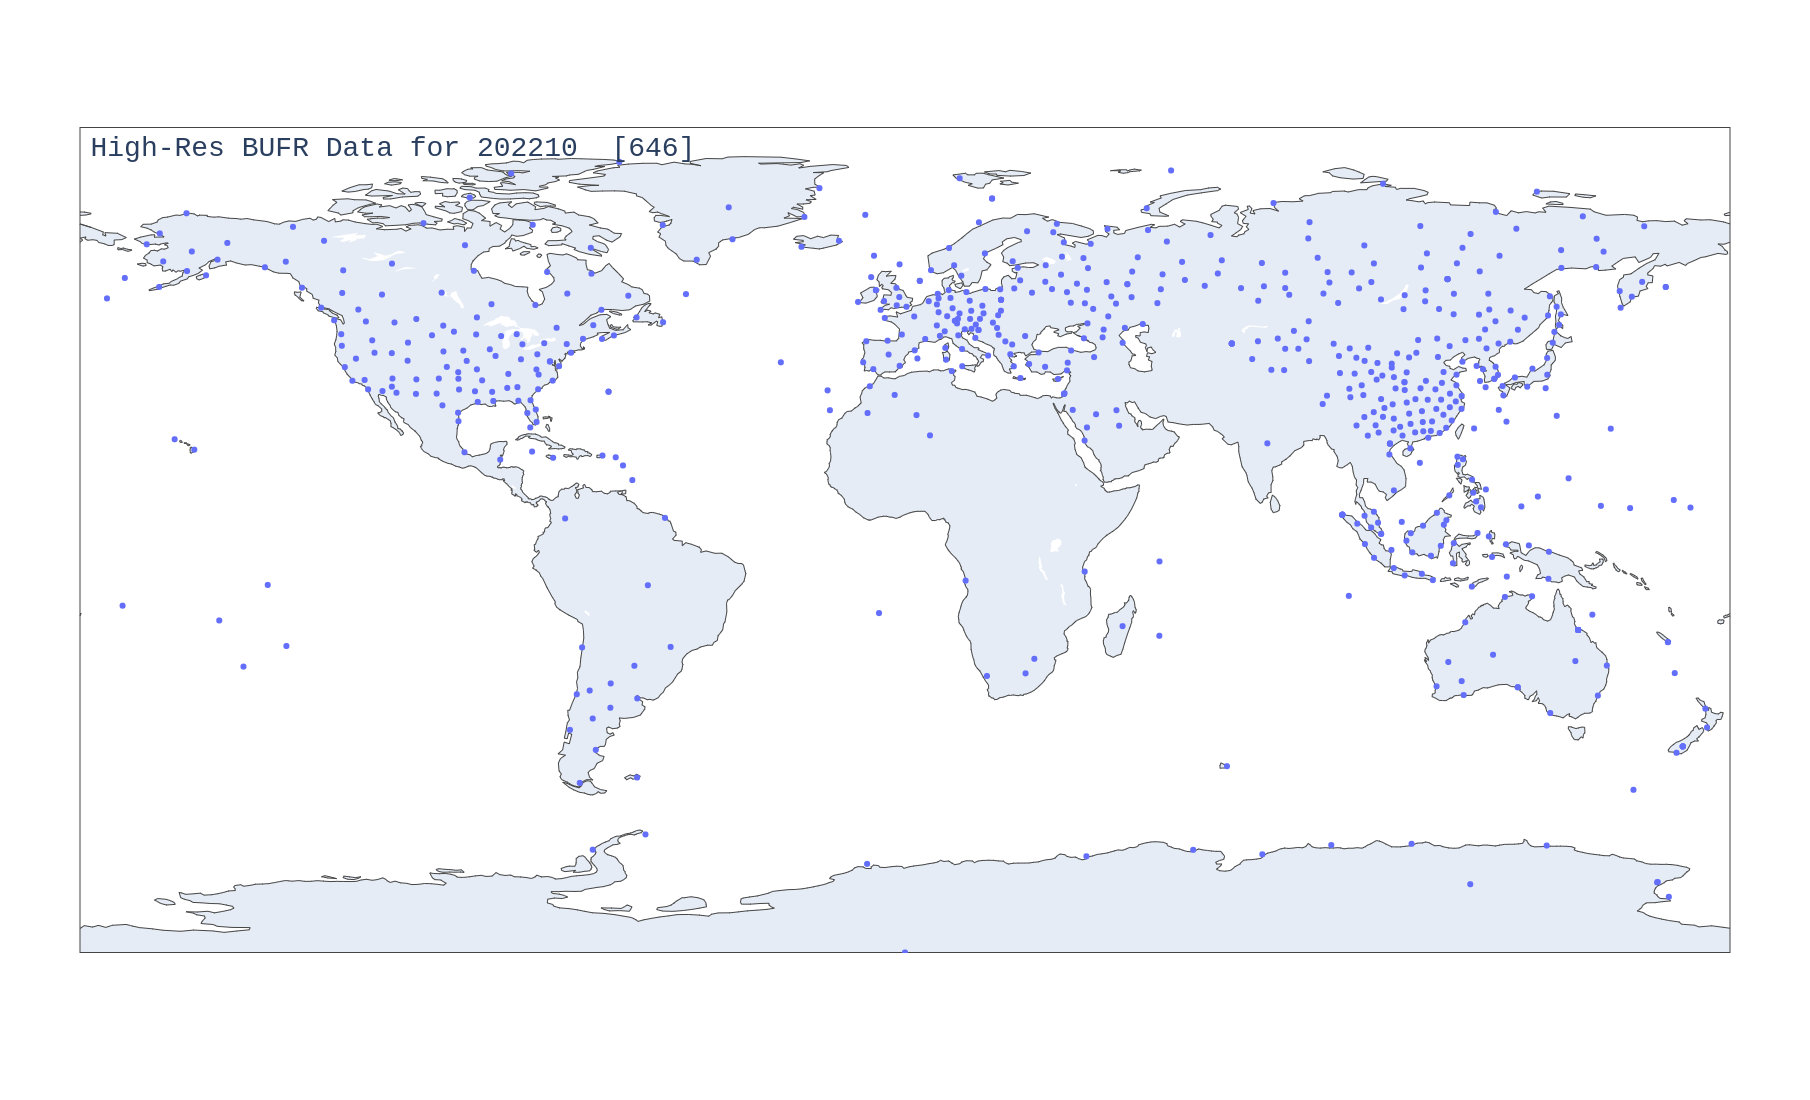

In [39]:
import plotly.express as px

map = px.scatter_geo(map_data,
                    lat=map_data.lat,
                    lon=map_data.lon,
                    hover_name="station")

map.update_layout(
        height=1100, width=1500,
        title= { 'text': 'High-Res BUFR Data for ' + date + '  [' + str(len(map_data.lat)) + ']' ,  "yref": "paper","y": 0.9, "yanchor": "bottom" },

        font=dict( family="Courier New, monospace", size=20, #color="RebeccaPurple"
        ),
        # margin=dict(l=20, r=20, t=0, b=5),
        legend=dict(font=dict(family="Courier New, monospace", size=25, color="black"), title = "Sensor Id"),
        legend_title=dict(font=dict(family="Courier New, monospace", size=25, color="blue"))
    )
    
map.show()

In [ ]:
data_dir = '/users/staff/federico/BUFR_CNR_EMANUELE_FABIO/ALL_DATA/d202210_c20221102/'
 
"""
def main():
    for f in os.listdir(data_dir):
        INPUT = data_dir + '/' + f
        try:
            data = read_bufr_highres(INPUT)
            
        except CodesInternalError as err:
            if VERBOSE:
                traceback.print_exc(file=sys.stderr)
            else:
                sys.stderr.write(err.msg + "\n")
            return 1
 
    
 
if __name__ == "__main__":
    sys.exit(main())
"""

In [ ]:
"""
filename = '/users/staff/federico/BUFR_CNR_EMANUELE_FABIO/d201410_c20171005/BTEM00012014102818.DC1.DAT'
filename = '/scratch/das/federico/databases_service2/BUFR_DIC2022/BTEF00012022103100.DC1.DAT'

file = open(filename)
# loop over the messages in the file
while 1:
    ibufr = codes_bufr_new_from_file(file)
    if ibufr is None:
        break
    # Read the BUFR headers info
    numberOfSubsets = codes_get(ibufr, 'numberOfSubsets')
    # unpack the data values
    codes_set(ibufr, 'unpack', 1)
    # Read the data values
    airTemperature = codes_get(ibufr,
    'airTemperature')
    codes_release(ibufr)
    
    print(airTemperature)
    
file.close()
"""